In [1]:
!pip install -Uqq fastbook

     |████████████████████████████████| 727kB 8.6MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 1.2MB 50.3MB/s 
     |████████████████████████████████| 194kB 53.4MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 


In [2]:
from fastbook import *
from fastai.callback.tracker import SaveModelCallback

import numpy as np
from tqdm.auto import tqdm
from plotnine import *
import shutil

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# !unzip "/content/drive/MyDrive/images_xray.zip" -d "/content/drive/MyDrive/images_xray/"

Archive:  /content/drive/MyDrive/images_xray.zip


In [5]:
path = Path('/content/drive/MyDrive/images_xray/images/')

In [6]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(512, method=ResizeMethod.Squish), 
    batch_tfms = [IntToFloatTensor(), Brightness(max_lighting = 0.2, p = 0.2), Contrast(max_lighting = 0.4, p = 0.4), *aug_transforms(size=512, flip_vert=True), Normalize.from_stats(*imagenet_stats)]
    )
dls = dblock.dataloaders(path, bs=64)

In [7]:
xb, yb = dls.one_batch()

xb.shape, yb.shape

(torch.Size([64, 3, 512, 512]), torch.Size([64]))

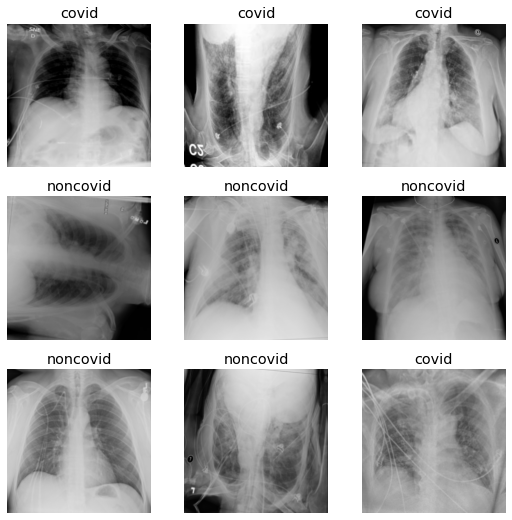

In [8]:
dls.train.show_batch(max_n=9, nrows=3)

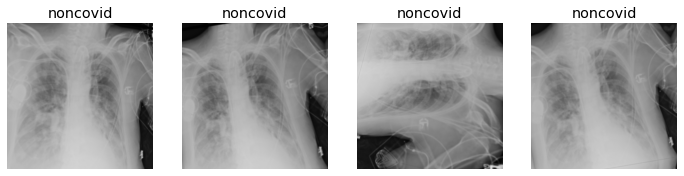

In [9]:
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [10]:
learn = cnn_learner(dls, 
                    resnet34, 
                    metrics=[accuracy, 
                             Precision(), 
                             Recall(), 
                             F1Score()]).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


In [11]:
defaults.device = torch.device('cuda')

In [12]:
learn.fine_tune(epochs=5,
          base_lr=1e-3,
          freeze_epochs=1,
          lr_mult=100,
          pct_start=0.2,
          div=5.0,-
          cbs=[SaveModelCallback(monitor='f1_score')])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.534357,0.282611,0.910833,0.880805,0.949917,0.914056,14:59


Better model found at epoch 0 with f1_score value: 0.9140562248995984.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.323742,0.199970,0.947500,0.932258,0.964942,0.948318,01:20
1,0.217634,0.168172,0.963333,0.958678,0.968280,0.963455,01:21
2,0.204481,0.150505,0.950833,0.939739,0.963272,0.951360,01:22
3,0.160195,0.135132,0.960833,0.946602,0.976628,0.961380,01:22
4,0.138457,0.143224,0.960000,0.943639,0.978297,0.960656,01:22


Better model found at epoch 0 with f1_score value: 0.9483182936833471.
Better model found at epoch 1 with f1_score value: 0.9634551495016612.


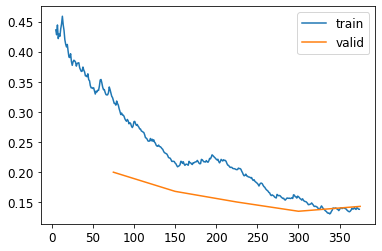

In [13]:
learn.recorder.plot_loss()

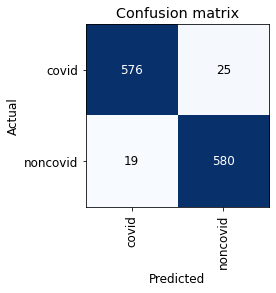

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [15]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]